In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


# Solving the nonlinear Schroedinger equation (NLSE) using PINNs
**Ref. [1]**: M. Raissi, P. Perdikaris, G.E. Karniadakis, *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving
nonlinear partial differential equations*, Journal of Computational Physics 378 (2019) 686–707, https://doi.org/10.1016/j.jcp.2018.10.045

We consider the initial value problem for the nonlinear Schroedinger equation from Ref. [1]: 
$$ iz_t + \frac{1}{2}z_{xx} + |z|^2z = 0,\quad x\in[-5,5],\quad t \in \left[0,\frac{\pi}{2}\right],$$
where $z(t,x) = u(t,x) + iv(t,x)$ is a comples-valued function. We impose the initial condition
$$z(0,x) = \frac{4}{e^x + e^{-x}}\equiv u_0(x)$$
and periodic boundary conditions
$$z(t,-5) = z(t,5),\quad z_x(t,-5) = z_x(t,5).$$
This code solves this equation using the PINNs approach introduced in Ref. [1]. 
We split NLSE into a system of PDEs for the real and complex parts of $z(t,x)$: 
$$
(u_t + iv_t) = \tfrac{i}{2}(u_{xx} + iv_{xx}) + i|u^2 + v^2|(u + iv).
$$
$$
\begin{cases}
u_t +\tfrac{1}{2}v_{xx} + |u^2 + v^2|v = 0\\
v_t -\tfrac{1}{2}u_{xx} - |u^2 + v^2|u = 0
\end{cases}
$$
We design a solution model as in Ref. [1]:
$$
\begin{bmatrix}u_{\theta}\\v_{\theta}\end{bmatrix} = \mathcal{N}(t,x;\theta),
$$
where $\mathcal{N}(t,x;\theta)$ is a neural network function with input and output dimensions equal to two, five layers, 100 neurons each, and the $\tanh$ activation function. 

The computational domain is the rectangle $[0,\tfrac{\pi}{2}]\times[-5,5]$ in the $(t,x)$-space.

The loss function is the sum of three terms,
$$
{\sf Loss}(\theta) = {\sf Loss}_{\sf IC}(\theta) + {\sf Loss}_{\sf BC}(\theta) + {\sf Loss}_{\sf PDF}(\theta),
$$
forcing the solution model to satisfy the initial conditions (IC), the boundary conditions (BC), and the PDE, respectively. $\theta$ is the vector of trainable parameters.
We take 
* $N_{\sf IC} = 50$ training points $-5< x_j< 5$ for the IC loss sampled from the uniform distribution $\mathcal{U}(-5,5)$,
* $N_{\sf BC} = 50$  training points $0\le t_j\le \tfrac{\pi}{2}$ for the boundary conditions loss sampled from the uniform distribution $\mathcal{U}(0,\tfrac{\pi}{2})$, and
* $N_{\sf PDE} = 20,000$ training points $(t_j,x_j)\in[0,\tfrac{\pi}{2}]\times[-5,5]$ for the PDE loss, sampled using the Latin Hypercube method https://en.wikipedia.org/wiki/Latin_hypercube_sampling.

The components of the loss are defined as the standard $L_2$-loss:
$$
{\sf Loss}_{\sf IC}(\theta) = \frac{1}{N_{\sf IC}}\sum_{j=1}^{N_{\sf IC}}\left\|\mathcal{N}(0,x_j;\theta)- \begin{bmatrix}u_0(x_j)\\0\end{bmatrix}\right\|^2,
$$
$$
{\sf Loss}_{\sf BC} = \frac{1}{N_{\sf BC}}\sum_{j=1}^{N_{\sf BC}}\left\|\mathcal{N}(t_j,-5;\theta)- \mathcal{N}(t_j,5;\theta)\right\|^2 + 
\frac{1}{N_{\sf BC}}\sum_{j=1}^{N_{\sf BC}}\left\|\mathcal{N}_x(t_j,-5;\theta)- \mathcal{N}_x(t_j,5;\theta)\right\|^2,
$$
$$
{\sf Loss}_{\sf PDE} = \frac{1}{N_{\sf PDE}}\sum_{j=1}^{N_{\sf PDE}}\left\|\frac{\partial}{\partial t} \mathcal{N}(t_j,x_j;\theta)+ \begin{bmatrix}0&1\\-1&0\end{bmatrix}\left[\frac{1}{2}\frac{\partial^2}{\partial x^2} \mathcal{N}(t_j,x_j;\theta) + \|\mathcal{N}(t_j,x_j;\theta)\|^2\mathcal{N}(t_j,x_j;\theta)\right]\right\|^2.
$$


In [4]:
# define the IC function

# The torch tensor-type potential function
def IC_func(x):
    return 2/torch.cosh(x) 
    

In [5]:
# define the architecture of the solution model 
class SolutionModelNN(torch.nn.Module):

    def __init__(self,in_size, hidden_size, out_size):
        super(SolutionModelNN, self).__init__()

        self.linear0 = torch.nn.Linear(in_size, hidden_size)
        self.activation0 = torch.nn.Tanh()
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation2 = torch.nn.Tanh()
        self.linear3 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation3 = torch.nn.Tanh()
        self.linear4 = torch.nn.Linear(hidden_size, out_size)
                              
    def forward(self,tx):
        NNmodel = self.linear0(tx)
        NNmodel = self.activation0(NNmodel)
        NNmodel = self.linear1(NNmodel)
        NNmodel = self.activation1(NNmodel)
        NNmodel = self.linear2(NNmodel)
        NNmodel = self.activation2(NNmodel)
        NNmodel = self.linear3(NNmodel)
        NNmodel = self.activation3(NNmodel)
        NNmodel = self.linear4(NNmodel)
        return NNmodel

# define the dimensions for the neural network
in_size = 2 # the dimension of input data points
hidden_size = 100 # the number of neurons in the hidden layer
out_size = 2 # the output size of the neural network

# print neural network
sol_model = SolutionModelNN(in_size, hidden_size, out_size)
print(sol_model)

SolutionModelNN(
  (linear0): Linear(in_features=2, out_features=100, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (activation1): Tanh()
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (activation2): Tanh()
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (activation3): Tanh()
  (linear4): Linear(in_features=100, out_features=2, bias=True)
)


In [6]:
# define the computational domain and generate training data

xmin = -5
xmax = 5
tmin = 0
tmax = 0.5*torch.tensor([torch.pi])

N_IC = 50
N_BC = 50
N_PDE = 20000

# training points for IC are sampled from the uniform distribution on [xmin,xmax]
x_IC = np.reshape(np.random.uniform(low = xmin, high = xmax, size = N_IC),(N_IC,1))
t_IC = tmin*np.ones_like(x_IC)
tx_IC = np.concatenate((t_IC,x_IC),axis = 1)

train_data_IC = torch.from_numpy(tx_IC).float()
train_data_IC.requires_grad_(True)

# training points for IC are sampled from the uniform distribution on [xmin,xmax]
t_BC = np.reshape(np.random.uniform(low = tmin, high = tmax, size = N_BC),(N_BC,1))
xmin_BC = xmin * np.ones_like(t_BC)
xmax_BC = xmax * np.ones_like(t_BC)
txmin_BC = np.concatenate((t_BC,xmin_BC),axis = 1)
txmax_BC = np.concatenate((t_BC,xmax_BC),axis = 1)

train_data_BCxmin = torch.from_numpy(txmin_BC).float()
train_data_BCxmin.requires_grad_(True)
train_data_BCxmax = torch.from_numpy(txmax_BC).float()
train_data_BCxmax.requires_grad_(True)

# Generate the Latin Hypercube sample in the unit hypercube [0, 1)^d
randperm = np.random.permutation(N_PDE)
tvals = np.linspace(tmin,tmax,N_PDE + 2)
xvals = np.linspace(xmin,xmax,N_PDE + 2)
xvals_aux = xvals[1:-1]
xvals_randperm = np.reshape(xvals_aux[randperm],(N_PDE,1))
tvals_aux = np.reshape(tvals[1:-1],(N_PDE,1))
tx_PDE = np.concatenate((tvals_aux,xvals_randperm),axis = 1)

train_data_PDE = torch.from_numpy(tx_PDE).float()
train_data_PDE.requires_grad_(True)


tensor([[ 7.8536e-05, -2.2106e+00],
        [ 1.5707e-04,  3.7181e+00],
        [ 2.3561e-04,  4.1830e+00],
        ...,
        [ 1.5706e+00, -5.6747e-02],
        [ 1.5706e+00, -3.4546e+00],
        [ 1.5707e+00, -1.3237e+00]], requires_grad=True)

Text(0.5, 1.0, 'Training points')

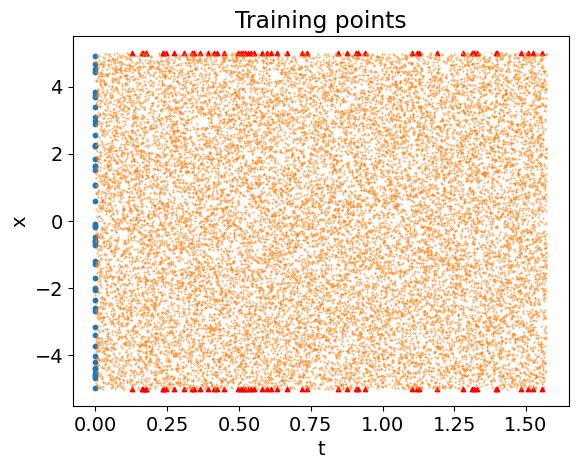

In [32]:
# visualize training points
plt.rcParams.update({'font.size': 14})
plt.scatter(t_IC,x_IC,marker = 'o',s = 10)
plt.scatter(t_BC,xmin_BC,marker = '^',color = 'red',s = 10)
plt.scatter(t_BC,xmax_BC,marker = '^',color = 'red',s = 10)
plt.scatter(tvals_aux,xvals_randperm,marker = '.',s = 0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.title('Training points')


In [7]:
# Set up training parameters 
# At each optimization step, we will use all boundary data, all initial data, 
# and a batch of interior points data.
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

size1,size2 = train_data_PDE.shape
print(f"PDE training data shape = ({size1},{size2})")
rhs = torch.zeros(size1,)

train_dataset = TensorDataset(train_data_PDE,rhs)

batch_size = int(np.round(size1/64))

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

# use the mean squared error loss
loss_fn = torch.nn.MSELoss()

# Here we define the optimizer with learning rate lr:
optimizer1 = optim.Adam(sol_model.parameters(), lr=1e-3)

# reduce the learning rate at the listed epochs by the factor of gamma
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[150,300,450], gamma=0.5)

# The number of training epochs. Each epoch is N_PDE/batch_size iterations
Nepochs = 2000
loss = np.zeros((Nepochs,3))

PDE training data shape = (20000,2)


In [8]:
import time
start_cpu_time = time.process_time()

for epoch in range(Nepochs):
    for X,y in train_dataloader:

        optimizer1.zero_grad()

        # evaluate the solution model at the training points
        Z = sol_model(X) # interior points batch (t_j,x_j)
        Z_IC = sol_model(train_data_IC) # the boundary t = tmin
        Z_BCxmin = sol_model(train_data_BCxmin) # the boundary x = xmin 
        Z_BCxmax = sol_model(train_data_BCxmax) # the boundary x = xmax 

        # compute the PDE loss
        U = Z[:,0]
        V = Z[:,1]
        Zabs_squared = U.pow(2) + V.pow(2) 
        
        derivU = torch.autograd.grad(U,X,allow_unused=True, retain_graph=True, \
                                     grad_outputs = torch.ones_like(U), create_graph=True)
        dU = derivU[0] # [dU/dt, dU/dx] 
        Ut = dU[:,0] # U_t
        Ux = dU[:,1] # U_x
        derivU2 = torch.autograd.grad(Ux, X,allow_unused=True,grad_outputs=torch.ones_like(Ux), \
                                      retain_graph=True, create_graph=True) # U_{xt}, U_{xx}
        Uxx = derivU2[0][:,1] # U_{xx}
        
        derivV = torch.autograd.grad(V,X,allow_unused=True, retain_graph=True, \
                                     grad_outputs = torch.ones_like(V), create_graph=True)
        dV = derivV[0] # [dU/dt, dU/dx] 
        Vt = dV[:,0] # V_t
        Vx = dV[:,1] # V_x
        derivV2 = torch.autograd.grad(Vx, X,allow_unused=True,grad_outputs=torch.ones_like(Vx), \
                                      retain_graph=True, create_graph=True) # V_{xt}, V_{xx}
        Vxx = derivV2[0][:,1] # V_{xx}

        PDE_U = Ut + 0.5*Vxx + Zabs_squared*V
        PDE_V = Vt - 0.5*Uxx - Zabs_squared*U
        Loss_PDE = loss_fn(PDE_U,y) + loss_fn(PDE_V,y)

        # compute the IC loss
        Loss_IC = loss_fn(Z_IC[:,0], IC_func(train_data_IC[:,1])) + loss_fn(Z_IC[:,1],torch.zeros_like(Z_IC[:,1]))

        # compute the BC loss
        U_per_bdry_xmin = Z_BCxmin[:,0]
        V_per_bdry_xmin = Z_BCxmin[:,1]
        U_per_bdry_xmax = Z_BCxmax[:,0]
        V_per_bdry_xmax = Z_BCxmax[:,1]

        derivU_per_bdry_xmin = torch.autograd.grad(U_per_bdry_xmin,train_data_BCxmin,allow_unused=True, \
                                                   retain_graph=True, grad_outputs = torch.ones_like(U_per_bdry_xmin), \
                                                   create_graph=True)
        Uxmin = derivU_per_bdry_xmin[0][:,1]

        derivV_per_bdry_xmin = torch.autograd.grad(V_per_bdry_xmin,train_data_BCxmin,allow_unused=True, retain_graph=True, \
                                                   grad_outputs = torch.ones_like(V_per_bdry_xmin), create_graph=True)
        Vxmin = derivV_per_bdry_xmin[0][:,1] 
         
        derivU_per_bdry_xmax = torch.autograd.grad(U_per_bdry_xmax,train_data_BCxmax,allow_unused=True, retain_graph=True,\
                                                   grad_outputs = torch.ones_like(U_per_bdry_xmax), create_graph=True)
        Uxmax = derivU_per_bdry_xmax[0][:,1]

        derivV_per_bdry_xmax = torch.autograd.grad(V_per_bdry_xmax,train_data_BCxmax,allow_unused=True, retain_graph=True, \
                                                   grad_outputs = torch.ones_like(V_per_bdry_xmax), create_graph=True)
        Vxmax = derivV_per_bdry_xmax[0][:,1] 

        Loss_BC = loss_fn(Z_BCxmin, Z_BCxmax) + loss_fn(Uxmin,Uxmax) + loss_fn(Vxmin,Vxmax)
    

        Loss = Loss_PDE + 10*Loss_IC + Loss_BC
        Loss.backward()
        optimizer1.step()

    scheduler1.step()
    loss[epoch,0] = Loss_PDE.detach()
    loss[epoch,1] = Loss_IC.detach()
    loss[epoch,2] = Loss_BC.detach()
    
    if epoch%100 == 0:
        print('Epoch: {}, Loss_PDE: {:.4e}, Loss_IC: {:.4e}, Loss_BC: {:.4e}'.format(epoch, Loss_PDE, Loss_IC, Loss_BC))

end_cpu_time = time.process_time()
cpu_execution_time = end_cpu_time - start_cpu_time
print(f"CPU Execution time: {cpu_execution_time:.6f} seconds")

Epoch: 0, Loss_PDE: 5.9703e-01, Loss_IC: 1.0329e-02, Loss_BC: 5.5496e-03
Epoch: 100, Loss_PDE: 1.3513e-02, Loss_IC: 6.5498e-04, Loss_BC: 2.7673e-04
Epoch: 200, Loss_PDE: 1.0279e-02, Loss_IC: 1.3501e-04, Loss_BC: 1.0793e-04
Epoch: 300, Loss_PDE: 7.0307e-03, Loss_IC: 6.4875e-05, Loss_BC: 4.6068e-05
Epoch: 400, Loss_PDE: 9.6324e-03, Loss_IC: 3.4589e-05, Loss_BC: 4.0942e-05
Epoch: 500, Loss_PDE: 9.5841e-04, Loss_IC: 1.8906e-05, Loss_BC: 2.0816e-05
Epoch: 600, Loss_PDE: 6.4200e-04, Loss_IC: 1.8075e-05, Loss_BC: 1.8016e-05
Epoch: 700, Loss_PDE: 1.9894e-03, Loss_IC: 8.1008e-06, Loss_BC: 1.8060e-05
Epoch: 800, Loss_PDE: 4.8112e-04, Loss_IC: 6.2312e-06, Loss_BC: 1.6061e-05
Epoch: 900, Loss_PDE: 2.9786e-04, Loss_IC: 7.7428e-06, Loss_BC: 1.7000e-05
Epoch: 1000, Loss_PDE: 3.6033e-04, Loss_IC: 5.4436e-06, Loss_BC: 1.9066e-05
Epoch: 1100, Loss_PDE: 6.6944e-04, Loss_IC: 3.6966e-06, Loss_BC: 1.1071e-05
Epoch: 1200, Loss_PDE: 3.7084e-03, Loss_IC: 2.7195e-05, Loss_BC: 3.7841e-05
Epoch: 1300, Loss_PDE: 1

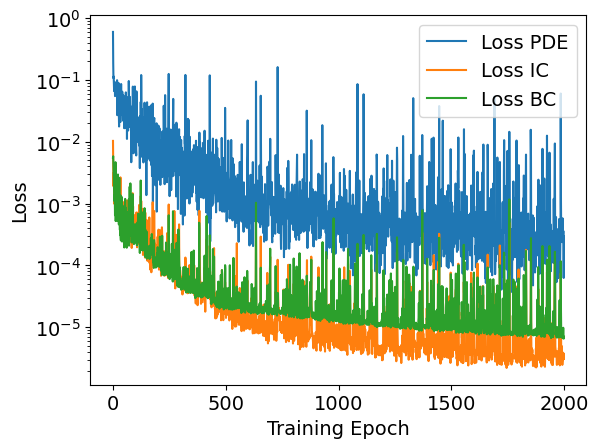

In [9]:
# Plot graphs of the losses
plt.rcParams.update({'font.size': 14})
plt.plot(np.arange(Nepochs),loss[:,0],label = "Loss PDE")
plt.plot(np.arange(Nepochs),loss[:,1],label = "Loss IC")
plt.plot(np.arange(Nepochs),loss[:,2],label = "Loss BC")
plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()


Text(0, 0.5, 'x')

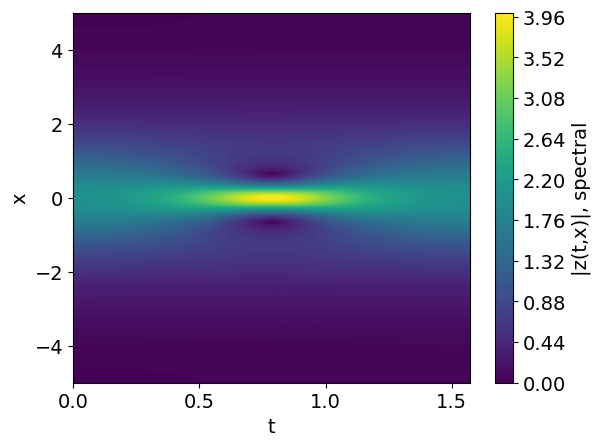

In [10]:
# Download and visualize the spectral solution

fname = "NLSE_spectral_solution.npz"
# np.savez(fname,t = tplot, x = x, u = np.real(sol_save), v = np.imag(sol_save))
spectral_sol_data = np.load(fname)
t = spectral_sol_data['t']
x = spectral_sol_data['x']
u_spectral = spectral_sol_data['u']
v_spectral = spectral_sol_data['v']

# visualize the solution as a heatmap
asol_sp = np.sqrt(u_spectral**2 + v_spectral**2)
asol_sp = np.concatenate((asol_sp,np.reshape(asol_sp[0,:],(1,np.size(t)))),axis = 0)

plt.rcParams.update({'font.size': 14})
plt.contourf(t,x,asol_sp,levels = 100)
plt.colorbar(label="|z(t,x)|, spectral", orientation="vertical")
plt.xlabel("t")
plt.ylabel("x")


Nt = 1001, Nx = 257, Ntx = 257257
shape of sol_NN is  (257257, 2)


Text(0, 0.5, 'x')

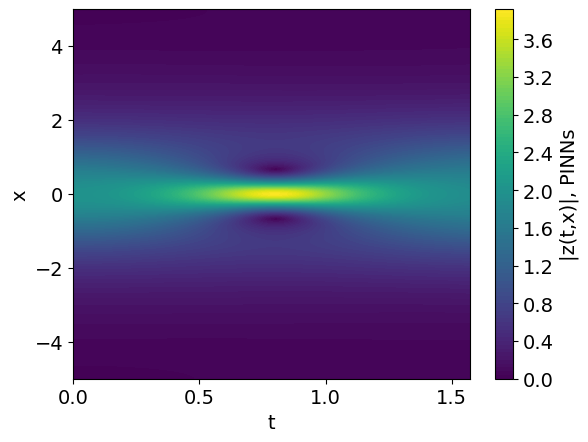

In [11]:
# Visualize the NN solution
Nt = np.size(t)
Nx = np.size(x)
Ntx = Nt*Nx
tmgrid,xmgrid = np.meshgrid(t,x)
t_vec = np.reshape(tmgrid, (Ntx,1))
x_vec = np.reshape(xmgrid, (Ntx,1))
tx_test_data = np.concatenate((t_vec,x_vec),axis=1)
print(f"Nt = {Nt}, Nx = {Nx}, Ntx = {Ntx}")

sol_NN = sol_model(torch.from_numpy(tx_test_data).float()).detach().numpy()
print("shape of sol_NN is ",np.shape(sol_NN))

u_nn = np.reshape(sol_NN[:,0],(Nx,Nt))
v_nn = np.reshape(sol_NN[:,1],(Nx,Nt))
asol_nn = np.sqrt(u_nn**2 + v_nn**2)

plt.rcParams.update({'font.size': 14})
plt.contourf(t,x,asol_nn,levels = 100)
plt.colorbar(label="|z(t,x)|, PINNs", orientation="vertical")
plt.xlabel("t")
plt.ylabel("x")


MAE = 1.0155e-02, RMSE = 2.1593e-02


Text(0, 0.5, 'x')

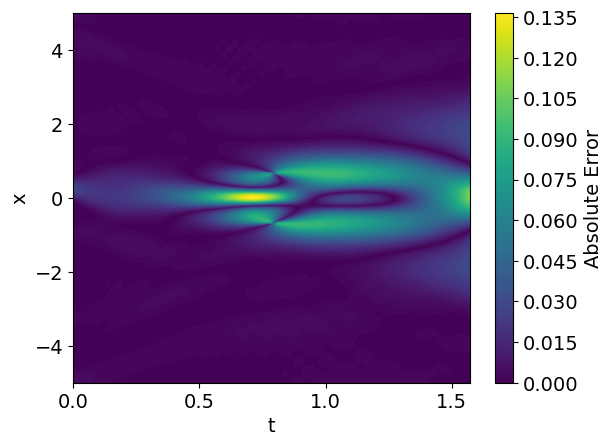

In [12]:
# compute the mean absolute error and the RMSE
AErr = np.abs(asol_nn - asol_sp)
MAE = np.sum(np.abs(AErr.flatten()))/Ntx
RMSE = np.sqrt(np.sum((AErr.flatten())**2)/Ntx)
print(f"MAE = {MAE:.4e}, RMSE = {RMSE:.4e}")

plt.contourf(t,x,AErr,levels = 100)
plt.colorbar(label="Absolute Error", orientation="vertical")
plt.xlabel("t")
plt.ylabel("x")


t =  0.59  ind =  375
t =  0.79  ind =  502
t =  0.98  ind =  623


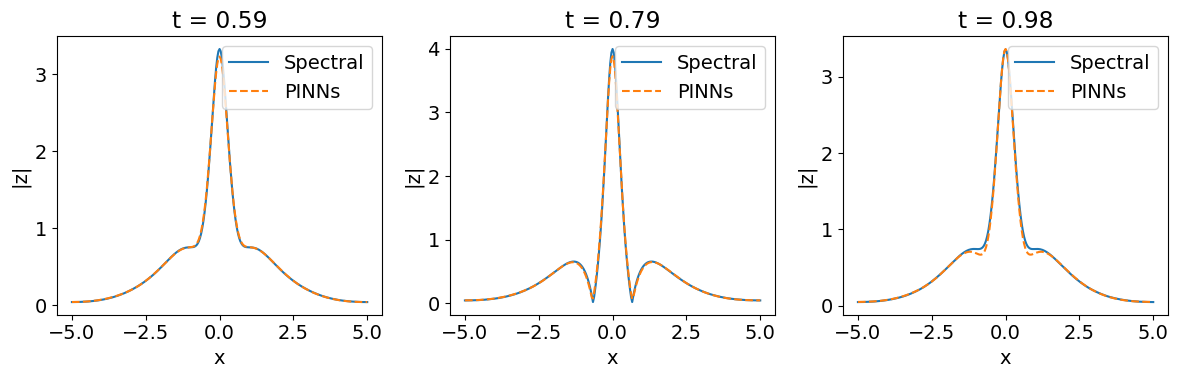

In [13]:
# Compare the PINNs and spectral solutions

t_query = np.array([0.59,0.79,0.98])
N_query = np.size(t_query)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
for j in range(N_query):
    ind = np.floor(t_query[j]/(t[1]-t[0])).astype(int)
    print("t = ",t_query[j]," ind = ",ind)
    axes[j].plot(x,asol_sp[:,ind],label = "Spectral")
    axes[j].plot(x,asol_nn[:,ind],linestyle = "--",label = "PINNs")
    axes[j].set_title(f"t = {t_query[j]:.2f}")
    axes[j].set_xlabel("x")
    axes[j].set_ylabel("|z|")
    axes[j].legend()

plt.tight_layout()  # Added for better spacing between subplots
plt.show()